# Model dla zbioru danych Adult

Imie, Nazwisko: Wojciech, Czajka  
Numer albumu: 235848  
Przedmiot: Analiza Danych 
Zbiór danych: https://archive.ics.uci.edu/ml/datasets/Adult  
Data: 19.12.2023.  

# Opis problemu

Zbiór danych "Adult" zawiera informacje o ponad 32 000 osobach. Spośród tych osób około 25 000 zarabia rocznie mniej niż 50 000 dolarów, a pozostałe osoby zarabiają powyżej tej kwoty. Celem analizy tych danych jest stworzenie modelu, który będzie w stanie dokładnie przewidzieć, czy dana osoba zarabia więcej niż 50 000 dolarów rocznie na podstawie informacji o jej cechach demograficznych, ekonomicznych i społecznych.

## Biblioteki

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Pobranie zbioru danych

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(url, header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                      'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                      'hours-per-week', 'native-country', 'income'], na_values=['?', ' ?', '? '])
print('Zbior sklada sie z', df.shape[0], 'rekordów i ', df.shape[1], 'kolumn')

Zbior sklada sie z 32561 rekordów i  15 kolumn


## Opis danych
### Statystyki opisowe

#### Informacje o kolumnach i typach danych

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


#### Podstawowe statystyki opisowe dla zmiennych numerycznych

In [4]:
print(df.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


#### Podstawowe statystyki opisowe dla zmiennych kategorycznych

In [5]:
print(df.describe(include=['object']))

       workclass education       marital-status       occupation relationship  \
count      30725     32561                32561            30718        32561   
unique         8        16                    7               14            6   
top      Private   HS-grad   Married-civ-spouse   Prof-specialty      Husband   
freq       22696     10501                14976             4140        13193   

          race    sex  native-country  income  
count    32561  32561           31978   32561  
unique       5      2              41       2  
top      White   Male   United-States   <=50K  
freq     27816  21790           29170   24720  


#### Liczba unikalnych wartości dla zmiennych kategorycznych

In [6]:
print(df.nunique())

age                  73
workclass             8
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       41
income                2
dtype: int64


### Wizualizacja danych

#### macierz korelacji między cechami

/tmp/ipykernel_31641/2857318094.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


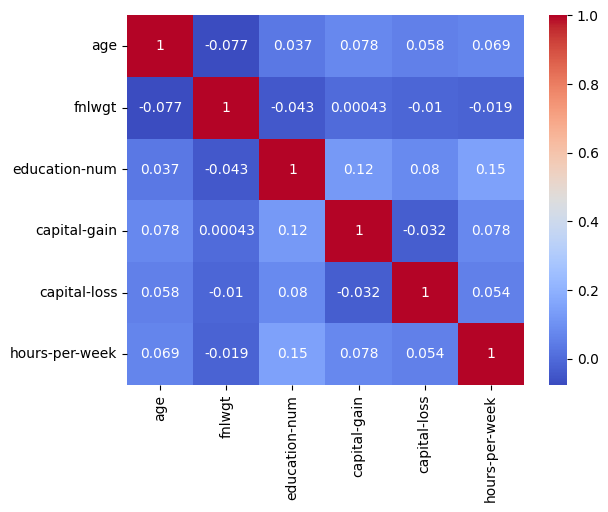

In [7]:
data = df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']]
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### histogram wieku

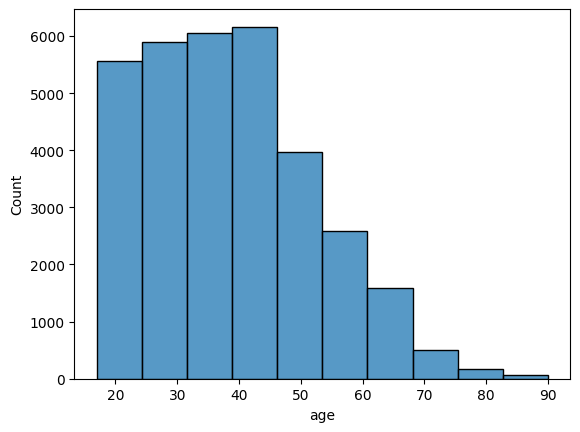

In [8]:
sns.histplot(data=df, x='age', bins=10)
plt.show()

#### macierz wykresów punktowych przedstawiających zależności pomiędzy każdą parą cech: age, education-num, hours-per-week, a income.

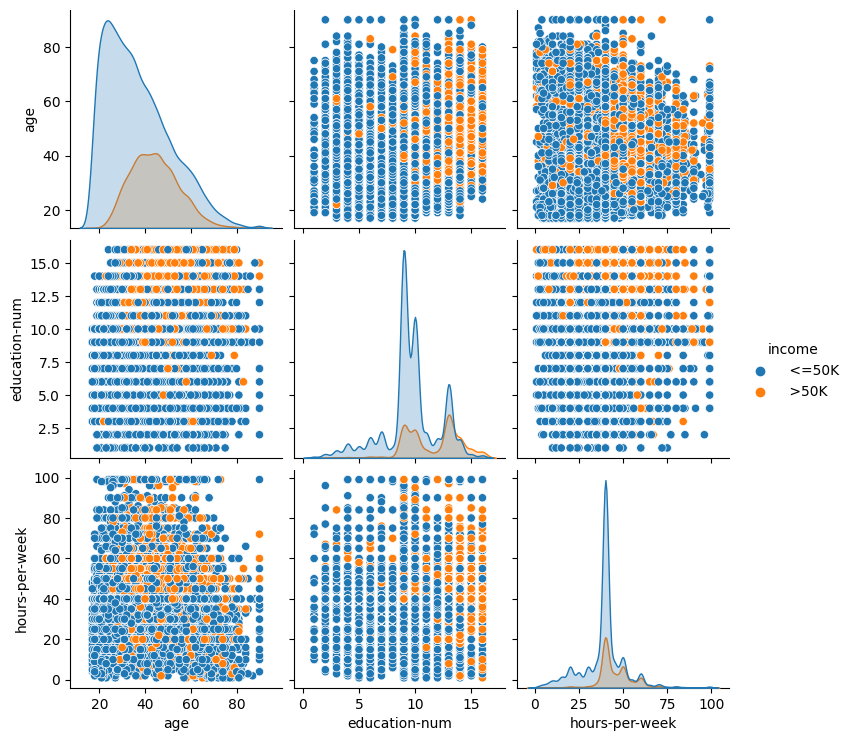

In [9]:
sns.pairplot(df[['age', 'education-num', 'hours-per-week', 'income']], hue='income')
plt.show()

#### wykresy słupkowe

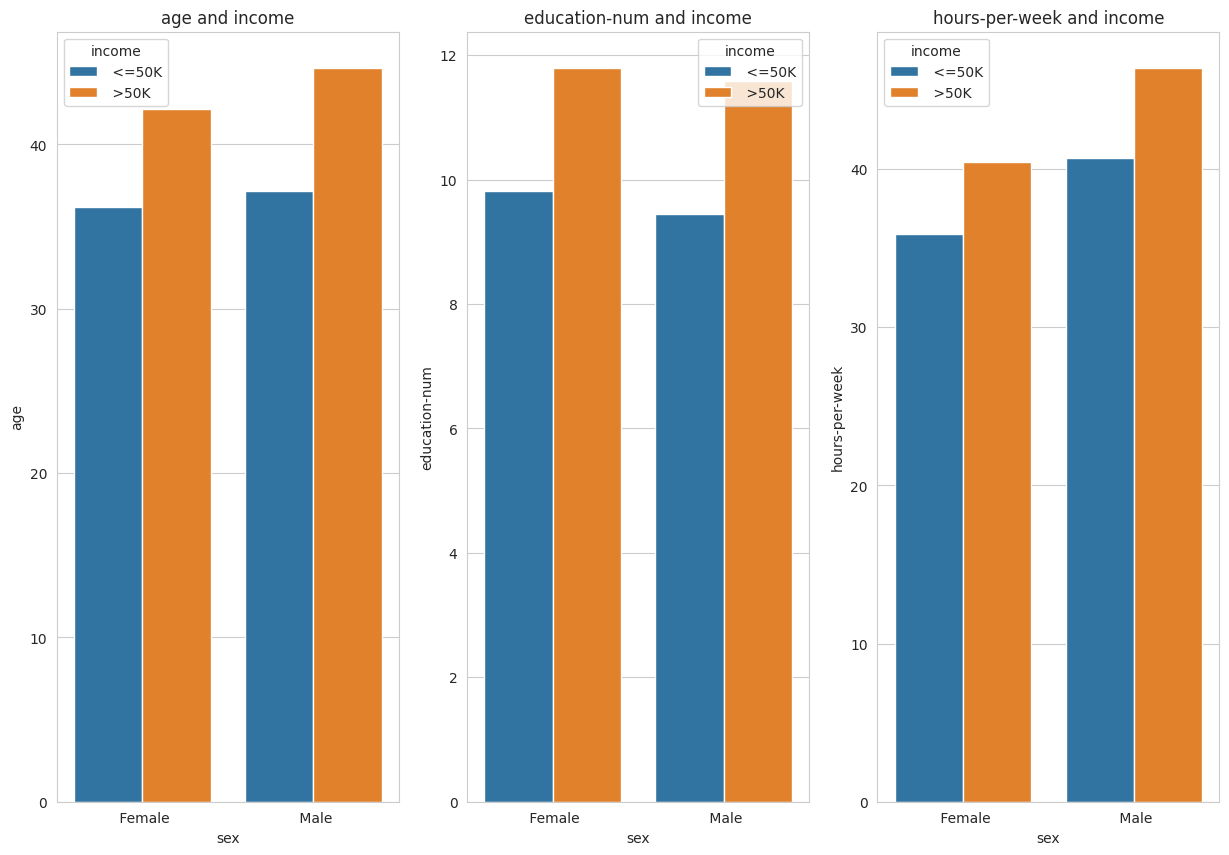

In [10]:
sns.set_style('whitegrid')

plot_data = df.groupby(['income', 'sex'])[['age', 'education-num', 'hours-per-week']].mean().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

sns.barplot(x='sex', y='age', hue='income', data=plot_data, ax=axes[0])
axes[0].set_xlabel('sex')
axes[0].set_ylabel('age')
axes[0].set_title('age and income')

sns.barplot(x='sex', y='education-num', hue='income', data=plot_data, ax=axes[1])
axes[1].set_xlabel('sex')
axes[1].set_ylabel('education-num')
axes[1].set_title('education-num and income')

sns.barplot(x='sex', y='hours-per-week', hue='income', data=plot_data, ax=axes[2])
axes[2].set_xlabel('sex')
axes[2].set_ylabel('hours-per-week')
axes[2].set_title('hours-per-week and income')

plt.show()

## Przygotowanie danych
### Czyszczenie danych 
#### Liczba brakujących danych: 

In [11]:
print(df.isna().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


#### Usunięcie rekordów z brakującymi wartościami

In [12]:
df.dropna(how='any',inplace=True)
print(df.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


#### Usunięcie zbędnych kolumn

In [13]:
df.drop(['fnlwgt', 'education'], axis=1, inplace=True)

### Przekształcenia danych

#### zamiana wartości kategorycznych na numeryczne

In [14]:
df['income'] = df['income'].str.strip()
df['sex'] = df['sex'].str.strip()
df['race'] = df['race'].str.strip()
df['marital-status'] = df['marital-status'].str.strip()
df['occupation'] = df['occupation'].str.strip()
df['relationship'] = df['relationship'].str.strip()
df['workclass'] = df['workclass'].str.strip()

df.replace({'income': {'<=50K': 0, '>50K': 1}, 
            'sex': {'Male': 0, 'Female': 1}, 
            'race': {'White': 0, 'Black': 1, 'Asian-Pac-Islander': 2, 
                     'Amer-Indian-Eskimo': 3, 'Other': 4},
            'marital-status': {'Married-spouse-absent': 0, 'Widowed': 1, 'Married-civ-spouse': 2, 'Separated': 3, 'Divorced': 4,'Never-married': 5, 'Married-AF-spouse': 6},
            'occupation': {'Farming-fishing': 1, 'Tech-support': 2, 'Adm-clerical': 3, 'Handlers-cleaners': 4, 
 'Prof-specialty': 5,'Machine-op-inspct': 6, 'Exec-managerial': 7,'Priv-house-serv': 8,'Craft-repair': 9,'Sales': 10, 'Transport-moving': 11, 'Armed-Forces': 12, 'Other-service': 13,'Protective-serv':14},
            'relationship': {'Husband': 0, 'Not-in-family': 1, 'Own-child': 2, 'Unmarried': 3, 
                             'Wife': 4, 'Other-relative': 5},
            'workclass': {'Private': 0, 'Self-emp-not-inc': 1, 'Self-emp-inc': 2, 'Federal-gov': 3, 'Local-gov': 4, 'State-gov': 5, 'Without-pay': 6, 'Never-worked': 7}
           }, inplace=True)

#### Standaryzacja age

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['age'] = scaler.fit_transform(df[['age']])

### Wybór cech

#### podział na zbiór cech i zbiór wyników

In [16]:
X = df.drop('income', axis=1)
X = df.loc[:, ['age', 'education-num', 'marital-status', 'occupation', 'hours-per-week', 'capital-gain']]
y = df['income']

## Tworzenie modelu i ocena (algorytmów)

### Podziel zbiór danych (trening i test)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

### Algorytmy uczące 
1) RandomForestClassifier to algorytm uczenia maszynowego, który stosuje metodę lasów losowych do klasyfikacji. Jest to złożony model zbudowany z wielu drzew decyzyjnych, które są uczone na losowo wybranych podzbiorach danych. Każde drzewo decyzyjne dokonuje klasyfikacji, a ostateczna decyzja klasyfikacyjna jest podejmowana na podstawie głosowania większościowego.  
2) Klasyfikator SVM (Support Vector Machine) to metoda uczenia maszynowego, która ma na celu znalezienie hiperpłaszczyzny, która najlepiej rozdziela dane wejściowe na dwie lub więcej klas. Algorytm SVM szuka hiperpłaszczyzny o maksymalnym marginesie, czyli odległości pomiędzy hiperpłaszczyzną a najbliższymi punktami danych należącymi do różnych klas.

#### RandomForestClassifier tworzenie i trenowanie modelu

In [18]:
rfc = RandomForestClassifier(n_estimators=100, random_state=None)
rfc.fit(X_train, y_train)

RandomForestClassifier()

#### Support Vector Machine (SVM) tworzenie i trenowanie modelu

In [19]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

### Testowanie algorytmów

#### Predykcja i ocena jakości klasyfikacji na zbiorze testowym dla RandomForestClassifier

In [20]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      6766
           1       0.68      0.61      0.64      2283

    accuracy                           0.83      9049
   macro avg       0.77      0.76      0.76      9049
weighted avg       0.82      0.83      0.82      9049



#### Predykcja i ocena jakości klasyfikacji na zbiorze testowym dla SVM

In [21]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      6766
           1       0.95      0.19      0.31      2283

    accuracy                           0.79      9049
   macro avg       0.87      0.59      0.59      9049
weighted avg       0.83      0.79      0.73      9049



### Czynności poprawiające wynik

####  Usunięcia wartości odstających

In [22]:
mean_h = X['hours-per-week'].mean()
std_h = X['hours-per-week'].std()

X.loc[(X['hours-per-week'] > mean_h + 3*std_h) | (X['hours-per-week'] < mean_h - 3*std_h), 'hours-per-week'] = mean_h

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

#### Dopasowanie hiperparametrów dla algorytmu RandomForestClassifier i jego ponowne trenowanie

In [23]:
param_grid_rfc = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10]}

rfc = RandomForestClassifier()
rfc = GridSearchCV(rfc, param_grid_rfc, cv=5)
rfc.fit(X_train, y_train)
print(rfc.best_params_)

{'max_depth': 10, 'n_estimators': 200}


### Ponowne testowanie algorytmów

#### Predykcja i ocena jakości klasyfikacji na zbiorze testowym dla RandomForestClassifier

In [24]:
y_pred = rfc.predict(X_test)
rand_idx = np.random.rand(1)
print(classification_report(y_test, y_pred))
print('Przykładowy wynik klasyfikacji:', rfc.predict(X_test.iloc[rand_idx]), 'dla rekordu:', X_test.iloc[rand_idx], y_test.iloc[rand_idx])

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2299
           1       0.74      0.56      0.64       718

    accuracy                           0.85      3017
   macro avg       0.81      0.75      0.77      3017
weighted avg       0.84      0.85      0.84      3017

Przykładowy wynik klasyfikacji: [0] dla rekordu:            age  education-num  marital-status  occupation  hours-per-week  \
20048  0.09589             11               5           2            45.0   

       capital-gain  
20048             0   20048    0
Name: income, dtype: int64


#### Macierz konfuzji dla klasyfikatora RandomForestClassifier

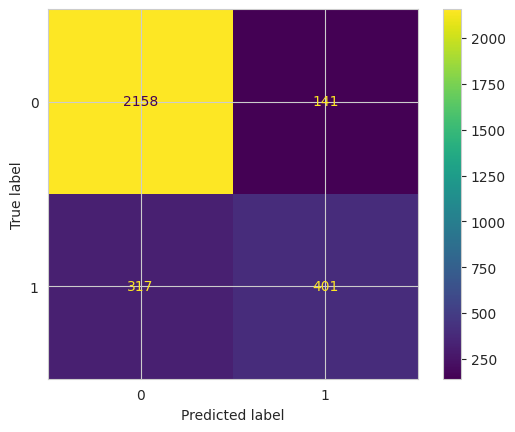

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

#### Predykcja i ocena jakości klasyfikacji na zbiorze testowym dla SVM

In [26]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
rand_idx = np.random.rand(1)
print(classification_report(y_test, y_pred))
print('Przykładowy wynik klasyfikacji:', svc.predict(X_test.iloc[rand_idx]), 'dla rekordu:', X_test.iloc[rand_idx], y_test.iloc[rand_idx])

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2299
           1       0.94      0.19      0.32       718

    accuracy                           0.80      3017
   macro avg       0.87      0.59      0.60      3017
weighted avg       0.83      0.80      0.75      3017

Przykładowy wynik klasyfikacji: [0] dla rekordu:            age  education-num  marital-status  occupation  hours-per-week  \
20048  0.09589             11               5           2            45.0   

       capital-gain  
20048             0   20048    0
Name: income, dtype: int64


#### Macierz konfuzji dla klasyfikatora SVM

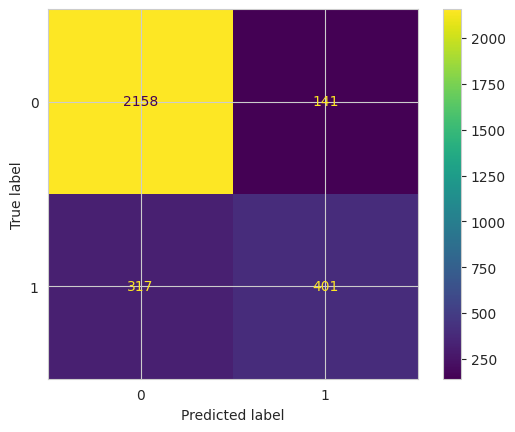

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp.plot()
plt.show()

### Podsumowanie

#### Wnioski
W przypadku klasyfikacji osób zarabiających powyżej lub poniżej 50K dolarów rocznie, oba modele osiągnęły zbliżoną jakość predykcji, z Accuracy wynoszącym około 85%. Wybrane cechy, które okazały się najważniejsze dla obu modeli to: "age", "education-num", "hours-per-week", "occupation", "capital-gain" oraz "marital_status".  

Wnioski, które możemy wyciągnąć z przeprowadzonej analizy, to m.in. fakt, że modele SVM i Random Forest mogą być skutecznie wykorzystane do klasyfikacji osób zarabiających powyżej lub poniżej określonej kwoty, przy czym SVM i Random Forest osiągają zbliżone wyniki predykcyjne.

Dodatkowo usunięcie parametrów odstającyh i dostosowanie  hiperparametrów klasyfikatora RandomForestClassifier, ma również pozytywny wpływ na jakość predykcji.

Warto również wspomnieć że model SVM jest bardzo wolny w użyciu.